# <span style='color:magenta'> Concevez une application au service de la santé publique </span>

L'agence **"Santé publique France"** a lancé un appel à projets pour trouver des **idées innovantes d’applications en lien** 
avec **l'alimentation**. A cet effet, un jeu de données a été mis a notre disposition. L'objectif de cette prémière partie d'analyse est:

1. Traiter le jeu de données:

    - Repérer des variables pertinentes pour les traitements à venir
    
    - Néttoyer les données en mettant en évidence les éventuelles valeurs manquantes, avec au moins 3 méthodes de traitement adaptées aux variables concernées
    
    - Identifier et en quantifier les éventuelles valeurs aberrantes de chaque variable.
    
    - Automatiser ces traitements pour éviter de répéter ces opérations.                                 

###  <span style='color:navy'> Import des librairies</span>

In [40]:
import numpy as np
from numpy import mean, std,percentile
import pandas as pd
from pandas.core.reshape.pivot import pivot_table
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy import stats, spatial
import sklearn
import math
import warnings
warnings.filterwarnings("ignore")

###  <span style='color:blue'> Import des données</span>

In [41]:
donnees=pd.read_csv('fr.openfoodfacts.org.products.csv',sep='\t' )

In [42]:
base= donnees.copy()

Comme indiqué dans l'appel à projet, les données sont organisées en sections. Selon le description des données sur le site  [openfoodfacts.org](https://world.openfoodfacts.org/data/data-fields.txt), il y a 5 sections:

1. "*general informations*" : les informations générales sur la fiche du produit
2. "*tags*" : un ensemble de tags
3. "*ingredients*": les ingrédients et additifs éventuels.
4. "*misc. data*" : des informations diverses
5. "*nutrition facts*" : des informations nutritionnelles

###  <span style='color:blue'> Propriétés générales de la base de données : </span>

Il s'agit ici de faire ressortir le nombre de lignes, colonnes, les valeurs manquantes et les lignes dupliquées. A cet effet nous allons créer une fonction pour le faire. Aussi une fonction sera crée pour chaque variables du dataframe

### <span style='color:olive'>Fonction pour les propriétés générales du dataframe  </span>

In [43]:
#Nombre de variables
def nb_col(base):
    return len(base.columns)

#Nombre d'observation
def nb_lignes(base):     
    return len(base)

#Nombre de valeurs manquantes
def nb_val_manquante(base):
    return base.isna().sum().sum()

#Pourcentage de valeurs manquantes
def freq_val_manquante(base):
    return base.isna().sum().sum()/(base.size)

#Nombre de lignes dupliqués
def nb_lignes_dupliq(base):
    return len(base)-len(base.drop_duplicates())

#Pourcentage de ligne dupliqués
def freq_lignes_dupliq(base):
    return nb_lignes_dupliq(base)/nb_lignes(base)

#Nombre de lignes entierement vide
def nb_lignes_vide(base):
    return base.isna().all(axis=1).sum()

#Pourcentage de ligne entierement vides
def freq_lignes_vide(base):
    return base.isna().all(axis=1).sum()/nb_lignes(base)

##Nombre de colonnes vides
def col_vide(base):
    return base.isnull().all().sum().sum()

##Pourcentage de colonnes vides
def freq_col_vide(base):
    return base.isnull().all().sum().sum()/nb_col(base)

##Nombre de colonnes ayant le même nom
def nom_col_dupliq(base):
    return base.columns.duplicated().sum()

## colonnes dupliquées en fonction des observation même si les noms sont identiques
def getDuplicateColumns(base):
    duplicateColumnNames = set()

    for x in range(base.shape[1]):
        col = base.iloc[:, x]

        for y in range(x + 1, base.shape[1]):
            otherCol = base.iloc[:, y]

            if col.equals(otherCol):
                duplicateColumnNames.add(base.columns.values[y])

    return list(duplicateColumnNames)

## Compter le nombre de colonnes dupliquées
def nb_col_dupliq(base):
    return len(getDuplicateColumns(base))

#### Recupérations des noms des colonnes et Dataframe
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]


#Affichage des statistiques globales sur le dataframe
def stat_globale(base):    
    print('Données : {}'.format(namestr(base, globals())))
    print('Nombre de variables : {}'.format(nb_col(base)))
    print('Nombre des observations : {}'.format(nb_lignes(base)))
    print('Nombre de valeurs manquantes : {}'.format(nb_val_manquante(base)))
    print('% valeurs manquantes : {:.2%}'.format(freq_val_manquante(base)))
    print('Nombre de lignes dupliquées : {}'.format(nb_lignes_dupliq(base)))
    print('% de lignes dupliquées : {:.2%}'.format(freq_lignes_dupliq(base)))
    print('Nombre de lignes vides : {}'.format(nb_lignes_vide(base)))
    print('% de lignes vides : {:.2%}'.format(freq_lignes_vide(base)))
    print('Nombre de Colonnes vides : {}'.format(col_vide(base)))
    print('% de colonnes vides : {:.2%}'.format(freq_col_vide(base)))
    print('Nombre de Colonnes ayant le même nom : {}'.format(nom_col_dupliq(base)))
    print('Nombre de Colonnes dupliquées : {}'.format(nb_col_dupliq(base)))
    return None

 #### <span style='color:blue'> Fonction pour afficher le type des variables </span>

In [44]:
def type_variable(base): 
    df = pd.DataFrame(base.dtypes)[0]
    list_var = pd.DataFrame(columns=['VARIABLES', 'TYPE'])
    list_var['VARIABLES']=base.columns
    list_var['TYPE']=list(df)
    return list_var

 ### <span style='color:olive'> Creation de la fonction pour les statistique de chaque variable </span>

In [45]:
def stat_variables(base):
    
    print('Data : {}'.format(namestr(base, globals())))
    df = pd.DataFrame(columns=['VARIABLES','TYPE','NB OBERVATIONS','DISTINCT(nb)','DISTINCT(%)',
                               'MANQUANTE(nb)','MANQUANTE(%)'])
    for col in base.columns:
        nobs=len(base)
        type_variable = base[col].dtypes
        v_distinct = len(base[col].unique())
        freq_distinct =round((len(base[col].unique())/len(base[col]))*100,2)
        v_manquantes = nb_val_manquante(base[col])
        freq_manquantes = round((freq_val_manquante(base[col]))*100,2)
        
        df = df.append(pd.DataFrame([[col,type_variable,nobs,v_distinct, freq_distinct,v_manquantes,
                                           freq_manquantes]], 
                                         columns=['VARIABLES','TYPE','NB OBERVATIONS','DISTINCT(nb)','DISTINCT(%)',
                               'MANQUANTE(nb)','MANQUANTE(%)'])).reset_index(drop=True)
    return df

 ### <span style='color:olive'> variables contenant des valeurs null </span>

In [46]:
def var_vide(df, limit):
  nb = ((base.isnull().sum() / base.shape[0])*100).sort_values(ascending=False).reset_index()
  nb.columns = ['Variable','Taux_de_Null']
  taux = nb[nb.Taux_de_Null >= limit]
  return taux

In [47]:
var_vide(base, 100)

,Variable,Taux_de_Null
0,water-hardness_100g,100.0
1,no_nutriments,100.0
2,ingredients_that_may_be_from_palm_oil,100.0
3,nutrition_grade_uk,100.0
4,nervonic-acid_100g,100.0
5,erucic-acid_100g,100.0
6,mead-acid_100g,100.0
7,elaidic-acid_100g,100.0
8,butyric-acid_100g,100.0
9,caproic-acid_100g,100.0


 ### <span style='color:olive'> Fonction de suppression des valeurs manquantes </span>

 #### <span style='color:blue'> Fonction pour l'affichage des valeurs manquantes </span>

In [48]:
def valeur_manquantes(base):
    dff = pd.DataFrame(columns=['VARIABLES', 'NB_V_MANQUANTE', '%_V_MANQUANTE'])
    dff['VARIABLES']=base.columns
    NB_manquante = list()
    FREQ_manquante= list()
    for col in base.columns:
        nb_manquante= nb_val_manquante(base[col])
        freq_manquante = round(freq_val_manquante(base[col])*100,2)
        NB_manquante.append(nb_manquante)
        FREQ_manquante.append(freq_manquante)
    dff['NB_V_MANQUANTE'] = list( NB_manquante)
    dff['%_V_MANQUANTE'] = list( FREQ_manquante)
    dff.sort_values("%_V_MANQUANTE", axis = 0, ascending = False, inplace = True, na_position ='first')
    return dff

In [49]:
valeur_manquantes(base)

,VARIABLES,NB_V_MANQUANTE,%_V_MANQUANTE
161,water-hardness_100g,320772,100.0
68,caproic-acid_100g,320772,100.0
47,ingredients_from_palm_oil,320772,100.0
50,ingredients_that_may_be_from_palm_oil,320772,100.0
52,nutrition_grade_uk,320772,100.0
...,...,...,...
6,last_modified_datetime,0,0.0
5,last_modified_t,0,0.0
4,created_datetime,9,0.0
3,created_t,3,0.0


 #### <span style='color:blue'> Fonction de la representation graphique des valeurs manquantes </span>

In [50]:
#Graphique des données manquantes
def graph_donnees_manquantes(df):
    data = valeur_manquantes(df).sort_values(by=['%_V_MANQUANTE'])
    fig = plt.figure(figsize=(13, 4))
    plt.xticks(rotation=90)
    plt.title('% de données manquantes')
    plt.ylabel('Pourcentage')
    plt.xlabel('variables')
    return plt.plot(data['VARIABLES'],data['%_V_MANQUANTE']);

 #### <span style='color:blue'> Fonction pour la suppression des variables ayant x% de valeurs manquantes </span>

In [51]:
#Suppression des valeurs manquantes par variables
def supp_v_manquantes_var(base,seuil):
    dff = valeur_manquantes(base)
    test = list()
    print('---------------------------------------------------------------------')
    print('Statistique des variables supprimées dans la base de données {}:'
          .format(namestr(base, globals())))
    print('---------------------------------------------------------------------')
    
    for row in dff.iterrows():        
        
        if float(row[1]['%_V_MANQUANTE'])>float(seuil):
            test.append(False)
        else:
            test.append(True) 
            
    var_restant = dff[test]['VARIABLES']
    print('Seuil : {}%'.format(float(seuil)))
    print('Nombre total de variable : {}'.format(len(base.columns)))
    print('Total variables supprimées : {}'.format(len(base.columns)-len(base[var_restant].columns)))
    print('Total variables restantes: {}'.format(len(base[var_restant].columns)))    
    return base[var_restant]

 #### <span style='color:blue'> Fonction pour la suppression des lignes et colonnes </span>

In [52]:
#Suppression des lignes vides
def suppr_lignes_vides(base):
    return base.dropna(axis=0,how='any',thresh=None,subset=None,inplace=True)

#Suppression des lignes avec un seuil de NaN
def suppr_seuil_lignes_vides(base, seuil):
    return base.dropna(thresh=seuil)

#Suppression des variables avec un seuil de NaN
def suppr_seuil_col(base,seuil):
    return data.dropna(axis=1,thresh=seuil)

#recuperation des variables quantitative:
def var_quanti(base):
    return base.select_dtypes(include=[np.number])

### <span style='color:blue'>Detection et suppression des valeurs abérrantes ou outliers </span>

#### <span style='color:blue'>Detection valeurs abérrantes ou outliers par la métodes du Zscore</span>

In [53]:
def Identification_outliers(base):
    
    df=base.select_dtypes(include=[np.number])
    
    #Creation des liste vides 
    outliersdf = []
    indexvals = []
    colswithoutliers = []
    for col in df.columns:
        
        #Moyenne et ecart type par colonne
        moy = np.mean(df[col])
        sd = np.std(df[col])
        
        #recuperations de tous les valeurs abérrantes par colonnes
        outliers = df.loc[((abs(df[col]-moy))/sd) > 3]
        
        #Recupération des colonnes ayant uniqument des outliers
        if len(outliers) == 0:
            pass
        else:
            outliersdf.append(outliers.values)
            indexvals.append(outliers.index.values)
            colswithoutliers.append(col)
            
    #Affichage des valeurs abérrantes par colonnes
    for number, item in enumerate(outliersdf):
        print('*************************')
        print('Variable: {}'.format(colswithoutliers[number]))
        print('*************************')
        
        df = pd.DataFrame(outliersdf[number], 
                           index=indexvals[number], 
                           columns=df.columns)
        print('Nombre de valeurs abbérantes: {}'.format(len(df[colswithoutliers[number]].values)))
        print('Index ou individus concernés:{}'.format(indexvals[number]))
        print('\n')
        
    return print('Nombre total de variable ayant des outliers: %d' % len(df.columns))

In [54]:
#Identification_outliers(base)

#### <span style='color:blue'>Fonction de detection des outliers par la métodes du boxplot </span>

In [55]:
def detection_outliers(df):
    data=df.select_dtypes(include=[np.number])
    degrees = 90
    fig = plt.figure(figsize=(15, 6))
    axes = plt.axes()
    plt.xticks(rotation=degrees)
    axes.set_ylim([-1e2,2e2])
    return sns.boxplot(data).set_title('boxplot des variables');


#### <span style='color:blue'>Fonction pour la suppression des outliers </span>

In [56]:
# def Supp_outlier(df, col_name):
#     q1 = df[col_name].quantile(0.25)
#     q3 = df[col_name].quantile(0.75)
#     iqr = q3-q1 #Interquartile range
#     fence_low  = q1-3*iqr
#     fence_high = q3+3*iqr
#     df_out = (df[col_name] > fence_low) & (df[col_name] < fence_high)
#     df=df.loc[df_out,:]
#     return df

In [57]:
# Supp_outlier(base_final,quant_variables )

In [58]:
#exportation des données en csv
def export(base):
    base.to_csv('features.csv')

# <span style='color:green'>Nettoyages des données </span>

In [59]:
# Propriété de la base
stat_globale(base)

Données : ['base']
Nombre de variables : 162
Nombre des observations : 320772
Nombre de valeurs manquantes : 39608589
% valeurs manquantes : 76.22%
Nombre de lignes dupliquées : 0
% de lignes dupliquées : 0.00%
Nombre de lignes vides : 0
% de lignes vides : 0.00%
Nombre de Colonnes vides : 16
% de colonnes vides : 9.88%
Nombre de Colonnes ayant le même nom : 0
Nombre de Colonnes dupliquées : 15


La base de données contient 320772 lignes et 162 colonnes. On a un taux élévé de valeurs manquantes soit 76,22%. De plus on 16 colonnes vides (qui sont considérées comme des colonnes dupliquées) et 0 lignes vides et 0 ligne dupliquée.

In [60]:
#Quelques statistiques sur les variables
stat_variables(base)

Data : ['base']


,VARIABLES,TYPE,NB OBERVATIONS,DISTINCT(nb),DISTINCT(%),MANQUANTE(nb),MANQUANTE(%)
0,code,object,320772,320639,99.96,23,0.01
1,url,object,320772,320750,99.99,23,0.01
2,creator,object,320772,3536,1.10,2,0.00
3,created_t,object,320772,189637,59.12,3,0.00
4,created_datetime,object,320772,189569,59.10,9,0.00
...,...,...,...,...,...,...,...
157,carbon-footprint_100g,float64,320772,203,0.06,320504,99.92
158,nutrition-score-fr_100g,float64,320772,56,0.02,99562,31.04
159,nutrition-score-uk_100g,float64,320772,56,0.02,99562,31.04
160,glycemic-index_100g,float64,320772,1,0.00,320772,100.00


In [61]:
#Valeurs manquantes
valeur_manquantes(base)

,VARIABLES,NB_V_MANQUANTE,%_V_MANQUANTE
161,water-hardness_100g,320772,100.0
68,caproic-acid_100g,320772,100.0
47,ingredients_from_palm_oil,320772,100.0
50,ingredients_that_may_be_from_palm_oil,320772,100.0
52,nutrition_grade_uk,320772,100.0
...,...,...,...
6,last_modified_datetime,0,0.0
5,last_modified_t,0,0.0
4,created_datetime,9,0.0
3,created_t,3,0.0


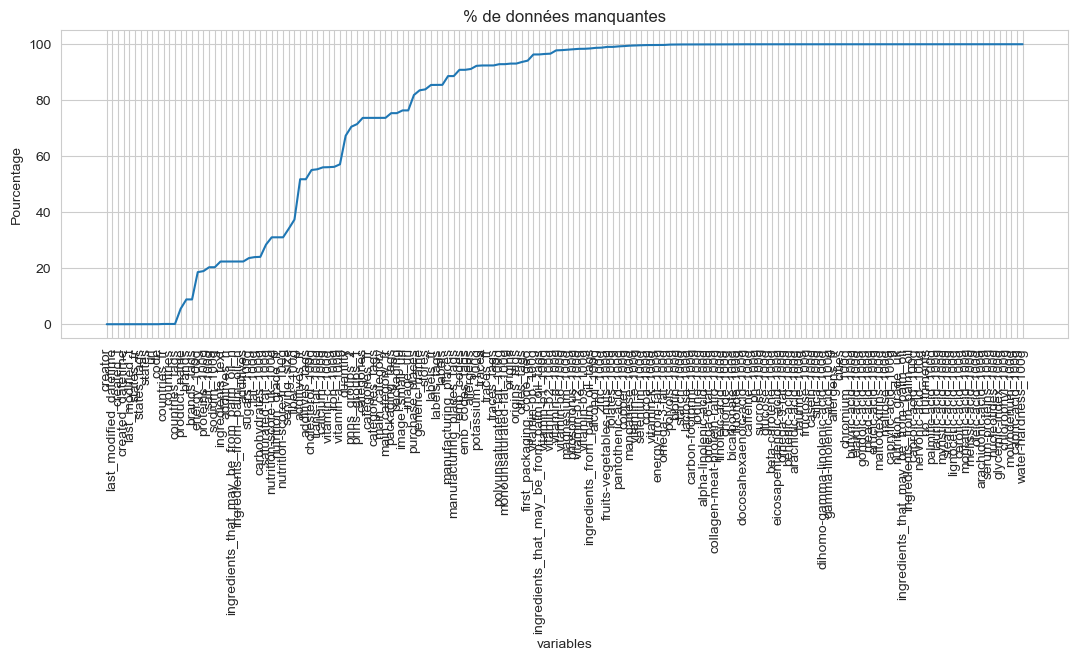

In [62]:
#Graphique des données manquantes
graph_donnees_manquantes(donnees)

Toutes les colonnes qui ont au moins 70% des données manquantes seront supprimées

In [63]:
#Suppression des valeurs manquantes par variables
base_final=supp_v_manquantes_var(base,40)

---------------------------------------------------------------------
Statistique des variables supprimées dans la base de données ['base']:
---------------------------------------------------------------------
Seuil : 40.0%
Nombre total de variable : 162
Total variables supprimées : 128
Total variables restantes: 34


In [64]:
stat_globale(base_final)

Données : ['base_final']
Nombre de variables : 34
Nombre des observations : 320772
Nombre de valeurs manquantes : 1534985
% valeurs manquantes : 14.07%
Nombre de lignes dupliquées : 1
% de lignes dupliquées : 0.00%
Nombre de lignes vides : 0
% de lignes vides : 0.00%
Nombre de Colonnes vides : 0
% de colonnes vides : 0.00%
Nombre de Colonnes ayant le même nom : 0
Nombre de Colonnes dupliquées : 0


In [65]:
#Suppression des lignes où le nom du produit n'existe pas
base_final= base_final.dropna(subset=['product_name'])
print("Donnees restantes:", base_final.shape)

Donnees restantes: (303010, 34)


In [66]:
# Suppression des doublons sur les produit en conservant les valeurs nulles
base_final.drop_duplicates(subset =['product_name'], keep = 'last', inplace=True)
print("Donnees restantes:", base_final.shape)

Donnees restantes: (221347, 34)


In [67]:
#Selectionons les variables quantitatives plus precisement 
#celles qui contiennent le mot clé 100g
def base_100g(base):
    cols_100g = [x for x in base.columns if  '_100g' in x]
    df = base.reindex(['nutriscore_score']+cols_100g,axis=1)
    return df

In [68]:
#Rindexer la base avec les noms des produits
base_final.set_index('product_name',inplace=True)

In [69]:
# interessons nous aux variables quantitatives qui sont les plus pertinentes:
quant_variables = ['fiber_100g', 'nutrition-score-uk_100g',
       'nutrition-score-fr_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'fat_100g', 'sugars_100g', 'sodium_100g', 'salt_100g', 'proteins_100g',
       'energy_100g']


Text(0.5, 1.0, 'boxplot des variables')

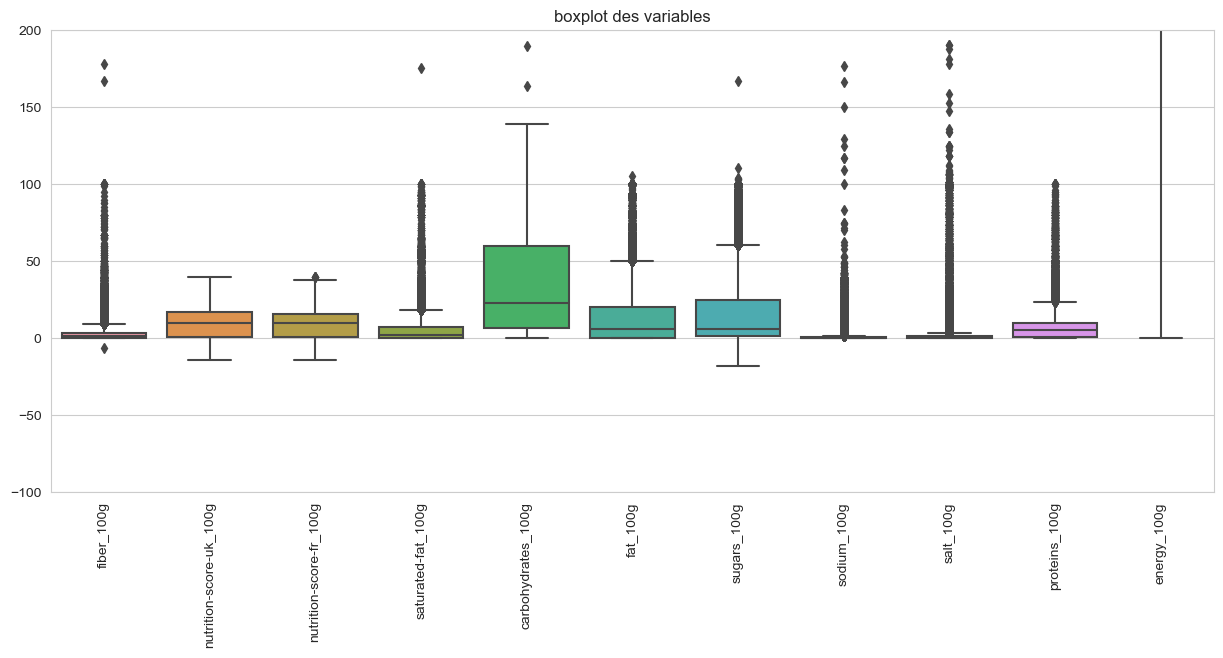

In [70]:

detection_outliers(base_final[quant_variables])

In [71]:
valeur_manquantes(base_final[quant_variables])

,VARIABLES,NB_V_MANQUANTE,%_V_MANQUANTE
0,fiber_100g,79288,35.82
1,nutrition-score-uk_100g,63770,28.81
2,nutrition-score-fr_100g,63770,28.81
3,saturated-fat_100g,58454,26.41
4,carbohydrates_100g,51889,23.44
5,fat_100g,51611,23.32
6,sugars_100g,47812,21.60
7,sodium_100g,41435,18.72
8,salt_100g,41399,18.70
9,proteins_100g,37949,17.14


In [72]:
features=base_final[quant_variables]
features

,fiber_100g,nutrition-score-uk_100g,nutrition-score-fr_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,sugars_100g,sodium_100g,salt_100g,proteins_100g,energy_100g
product_name,,,,,,,,,,,
Banana Chips Sweetened (Whole),3.6,14.0,14.0,28.57,64.29,28.57,14.29,0.000,0.00000,3.57,2243.0
Organic Salted Nut Mix,7.1,12.0,12.0,5.36,17.86,57.14,3.57,0.482,1.22428,17.86,2540.0
Breadshop Honey Gone Nuts Granola,7.7,NaN,NaN,1.92,63.46,18.27,11.54,NaN,NaN,13.46,1933.0
Organic Dark Chocolate Minis,7.5,NaN,NaN,22.50,55.00,37.50,42.50,NaN,NaN,5.00,2406.0
Organic Adzuki Beans,12.5,NaN,NaN,NaN,62.50,1.04,NaN,NaN,NaN,22.92,1393.0
...,...,...,...,...,...,...,...,...,...,...,...
Tomato & ricotta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Mint Melange Tea A Blend Of Peppermint, Lemon Grass And Spearmint",0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00000,0.00,0.0
乐吧泡菜味薯片,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <span style='color:blue'>Distribution des variables </span>

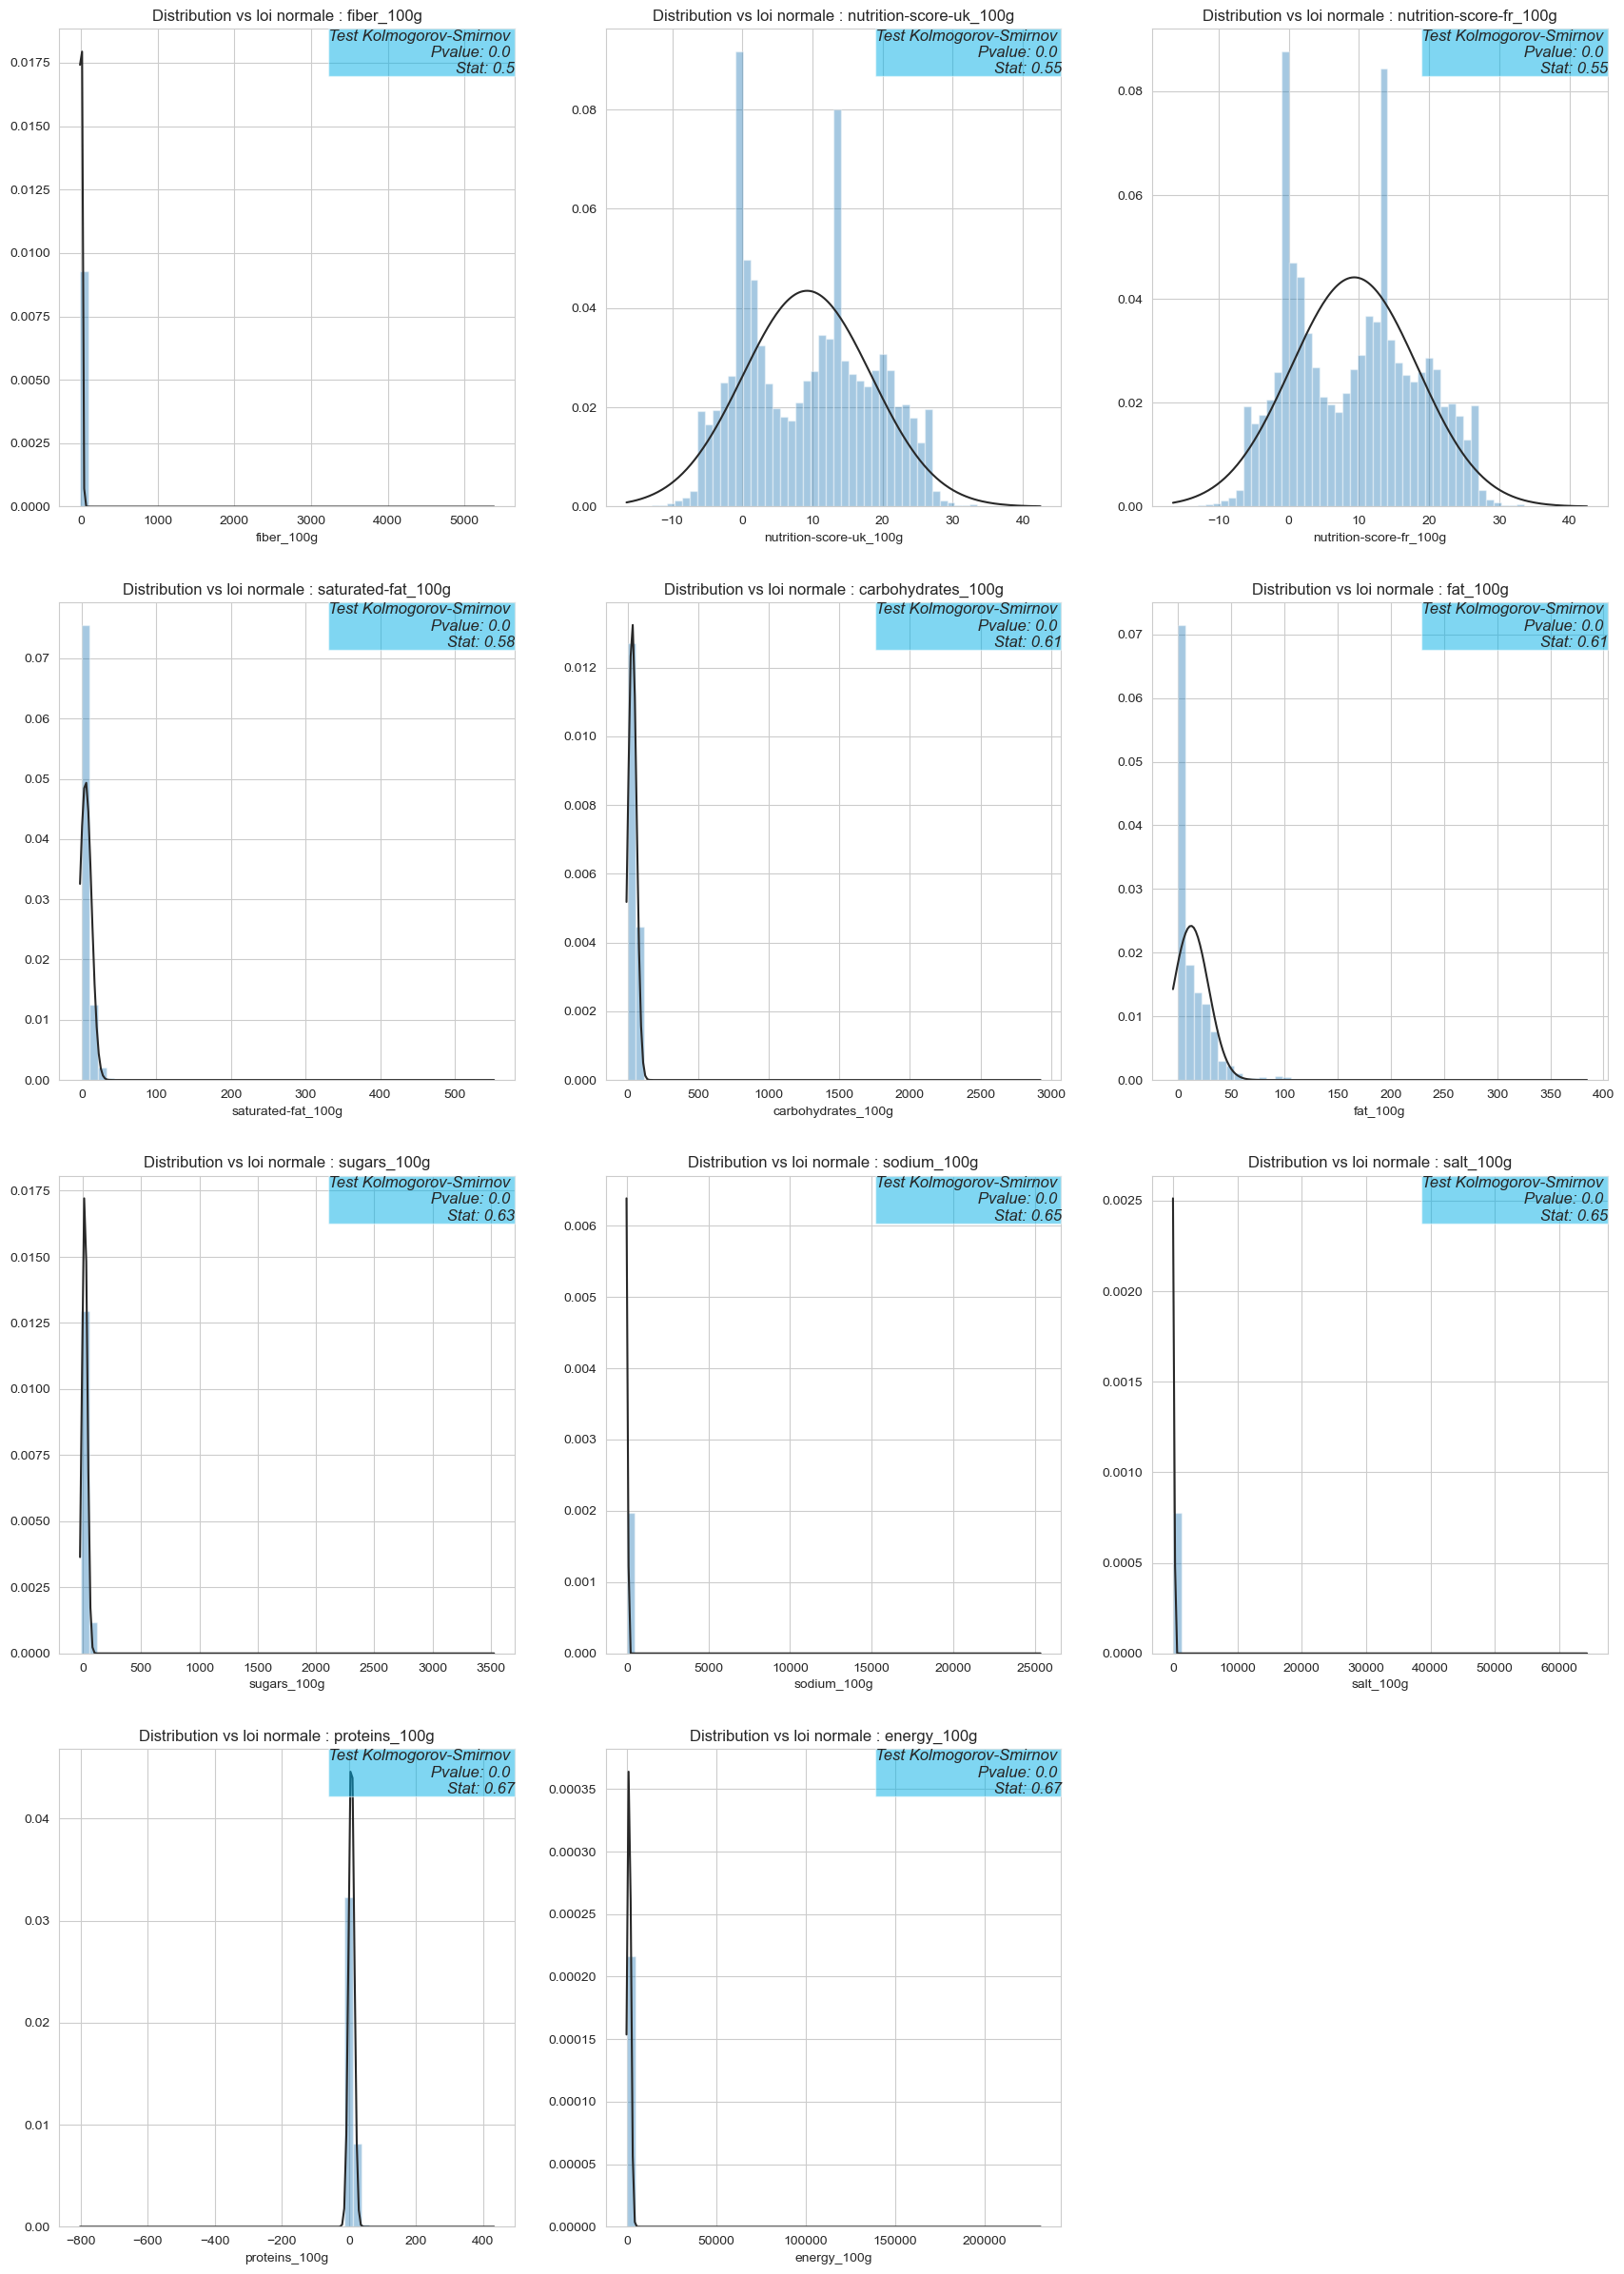

In [73]:
def distribtution():
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(21,30))
    sub = 0
    for i in range(len(quant_variables)):
        fig.add_subplot(4,3,i+1)

        left, width = 0, 1
        bottom, height = 0, 1
        right = left + width
        top = bottom + height

        colonne = quant_variables[i]
        kstest = stats.kstest(features[colonne].notnull(),'norm')
        ax = sns.distplot(features[colonne], fit=stats.norm, kde=False)
        ax.set_title("Distribution vs loi normale : {}".format(colonne))
        ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
                horizontalalignment='right',
                verticalalignment='top',
                style='italic', transform=ax.transAxes, fontsize = 12,
                bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
        sub += 1
    plt.show()
    
distribtution()


In [74]:
# def findOutliers(df , col):
#     global inf,sup
#     q1, q3 = np.quantile(df[col], 0.25), np.quantile(df[col], 0.75)
#     iqr = q1 - q3
#     ecart = iqr*3
#     inf=q1-ecart
#     sup=q3+ecart
#     outliers=df[(df[col]<(inf))|(df[col]>(sup))]
#     return print('Total outliers are', outliers.shape[0])


# def deleteOutliers(df, col):
#     q1, q3 = np.quantile(df[col], 0.25), np.quantile(df[col], 0.75)
#     iqr = q1 - q3
#     df_out = df.loc[~((df[col]< (q1-1.5*iqr)) & (df[col] > (q3+1.5*iqr)))]
#     return df_out

In [75]:
# quant_variables = ['fiber_100g', 'nutrition-score-uk_100g',
#        'nutrition-score-fr_100g', 'saturated-fat_100g', 'carbohydrates_100g',
#        'fat_100g', 'sugars_100g', 'sodium_100g', 'salt_100g', 'proteins_100g',
#        'energy_100g']

# for var in quant_variables :
#     findOutliers(features,var);
#     features = features.loc[(features[var]<inf) & (features[var]>sup)];

In [76]:
features

,fiber_100g,nutrition-score-uk_100g,nutrition-score-fr_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,sugars_100g,sodium_100g,salt_100g,proteins_100g,energy_100g
product_name,,,,,,,,,,,
Banana Chips Sweetened (Whole),3.6,14.0,14.0,28.57,64.29,28.57,14.29,0.000,0.00000,3.57,2243.0
Organic Salted Nut Mix,7.1,12.0,12.0,5.36,17.86,57.14,3.57,0.482,1.22428,17.86,2540.0
Breadshop Honey Gone Nuts Granola,7.7,NaN,NaN,1.92,63.46,18.27,11.54,NaN,NaN,13.46,1933.0
Organic Dark Chocolate Minis,7.5,NaN,NaN,22.50,55.00,37.50,42.50,NaN,NaN,5.00,2406.0
Organic Adzuki Beans,12.5,NaN,NaN,NaN,62.50,1.04,NaN,NaN,NaN,22.92,1393.0
...,...,...,...,...,...,...,...,...,...,...,...
Tomato & ricotta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Mint Melange Tea A Blend Of Peppermint, Lemon Grass And Spearmint",0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00000,0.00,0.0
乐吧泡菜味薯片,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#Suppression des outliers (valeurs comprise entre 0 et 100)
quant_variables = ['fiber_100g', 'nutrition-score-uk_100g',
       'nutrition-score-fr_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'fat_100g', 'sugars_100g', 'sodium_100g', 'salt_100g', 'proteins_100g',
       'energy_100g']

features=features[~(features[quant_variables]<0).any(axis=1)]
features=features[~(features[quant_variables]>100).any(axis=1)]
print("Donnees restantes:",features.shape)

Donnees restantes: (47440, 11)


In [40]:
#Nous allons traiter la variable energy_100G a part entiere car exprimé en KJ

print("energy_100g")
print("Valeur max:",max(features['energy_100g'].values))
print("Valeur moyenne:",np.nanmean(features['energy_100g'].values))
Q3 = round(np.nanpercentile(features['energy_100g'].values, 75))
D = round(np.nanpercentile(features['energy_100g'].values, 90))
print("Le 3iéme quartile:",Q3)
print("Le dernier décile",D)

energy_100g
Valeur max: nan
Valeur moyenne: 25.99016015775298
Le 3iéme quartile: 63
Le dernier décile 84


In [41]:
#Suppression des lignes ayants des valeurs supérieurs à 2151
features=features[~(features[['energy_100g']]>84).any(axis=1)]
print("Donnees restantes:",features.shape)

Donnees restantes: (46540, 11)


In [42]:
# #Rindexer la base avec les noms des produits
# base_final.set_index('product_name',inplace=True)

In [43]:
#Suppression des lignes vide
features.dropna(how='all', inplace = True)
features = features.loc[~((features[quant_variables]==0) |
                          (features[quant_variables].isnull())).all(axis=1)]
print("Donnees restantes:", features.shape)

Donnees restantes: (8271, 11)


In [39]:
#Supression des lignes ayant plus de 30% de données manquantes
# Nombre de données manquantes par lignes
q=features.isnull().sum(axis=1)
q = q.to_frame('Nb_NaN')
# Affichage des individus ayant au moins 30% de données manqauantes 30%*11indicateur egale environ 3
cond=q['Nb_NaN']>=3
#q[cond]
# Recuperation des index à supprimer
ind_supr=q[cond].index.to_list()
features.drop(index=ind_supr,axis=0, inplace=True)
print("Donnees restantes:", features.shape)

Donnees restantes: (4322, 11)


In [45]:
features

,fiber_100g,nutrition-score-uk_100g,nutrition-score-fr_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,sugars_100g,sodium_100g,salt_100g,proteins_100g,energy_100g
product_name,,,,,,,,,,,
Diced In Tomato Juice,0.8,1.0,1.0,0.0,4.62,0.0,3.08,0.223000,0.566420,0.77,79.0
Diet Decaffeinated Tea,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.006000,0.015240,0.00,0.0
Caffeine Free Unsweetened Tea,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.006000,0.015240,0.00,0.0
Cut Extra Green Beans,1.7,0.0,0.0,0.0,3.33,0.0,1.67,0.242000,0.614680,0.83,71.0
"Psst..., Sugar Free Gelatin, Strawberry Banana, Lime, Orange",NaN,0.0,0.0,0.0,0.00,0.0,0.00,0.016000,0.040640,1.09,21.0
...,...,...,...,...,...,...,...,...,...,...,...
Red Seal Green Tea,0.0,0.0,1.0,0.0,1.00,0.0,0.00,0.002000,0.005080,0.00,8.0
Jabal Akhdar Pure Natural Water,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.005950,0.015113,0.00,0.0
SKOL,0.0,4.0,4.0,1.0,NaN,NaN,1.00,0.393701,1.000000,1.00,4.0


Text(0.5, 1.0, 'boxplot des variables')

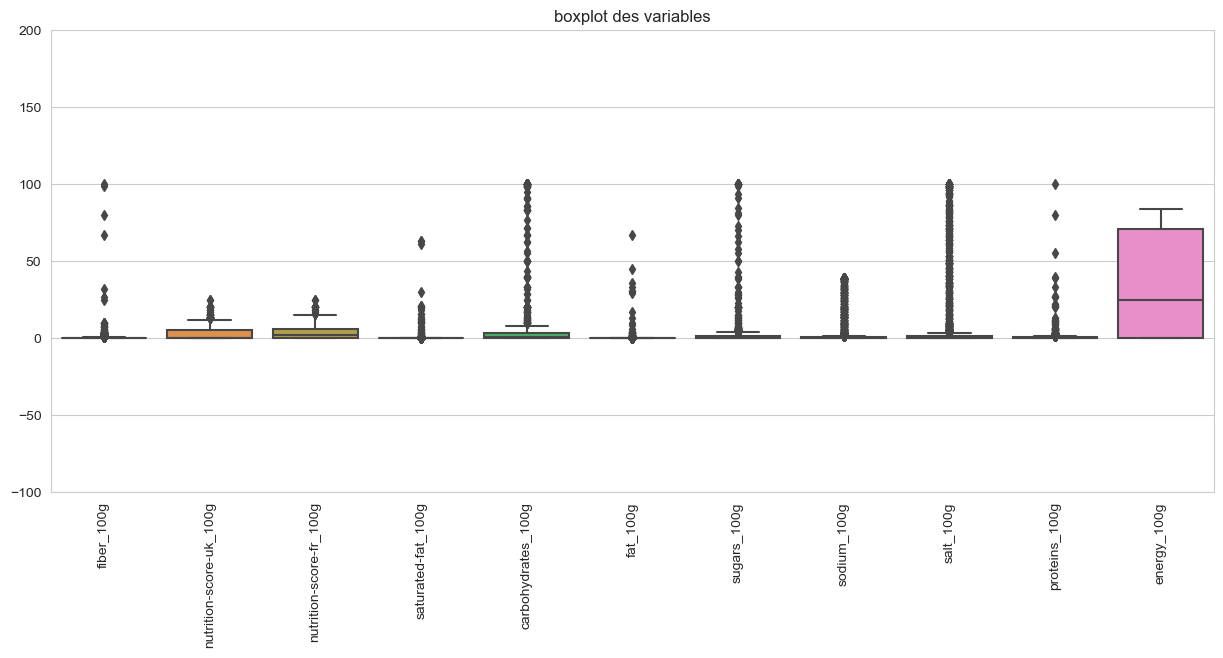

In [46]:
detection_outliers(features)

###  <span style='color:blue'> Traitement des données manquantes </span>

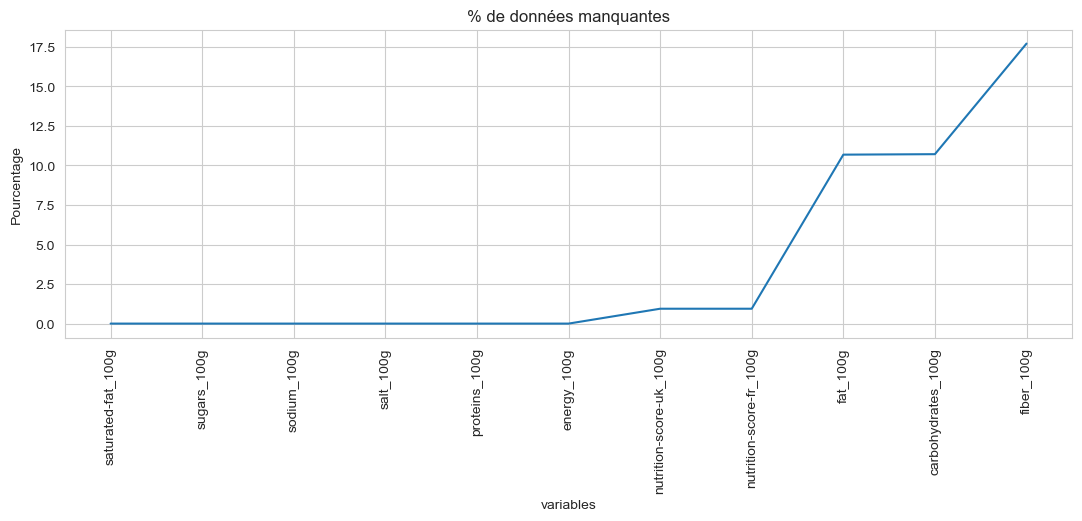

In [47]:
graph_donnees_manquantes(features)

####  <span style='color:blue'> Imputation par la médiane </span>

In [48]:
# Remplacement des valeurs manquantes par la mediane de chaque colonne
features.fillna(features.median(), inplace=True)

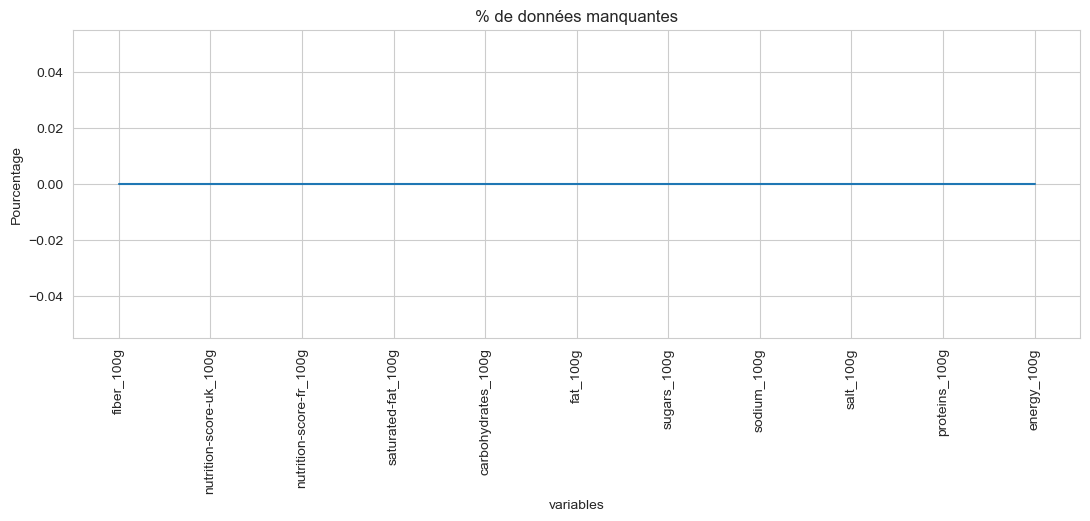

In [49]:
graph_donnees_manquantes(features)

In [52]:
export(features)